Setup awal

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import KFold
import numpy as np
import os
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Transformasi gambar

In [5]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_dir = "/kaggle/input/datasetta2/Multi-Class Driver Behavior Image Dataset"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Jumlah total data:", len(dataset))
print("Kelas:", dataset.classes)

Jumlah total data: 7276
Kelas: ['other_activities', 'safe_driving', 'talking_phone', 'texting_phone', 'turning']


Splitting dataset

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(len(train_dataset), len(val_dataset), len(test_dataset))

5820 727 729


Setup k-fold=5

In [8]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

Definisikan fungsi training dan validation

In [9]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"  🔹Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc
    
def validate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"  🔸Val Loss: {epoch_loss:.4f} | Val Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

In [10]:
num_classes = len(dataset.classes)
print("num_classes =", num_classes)

num_classes = 5


Training model mobilenet menggunakan data train

In [11]:
import time
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
import pandas as pd  
import os

# === Hyperparameters ===
num_classes = len(dataset.classes)
batch_size = 32
epochs = 15
learning_rate = 1e-4
weight_decay = 1e-2
k_folds = 5

# Folder untuk menyimpan hasil training
base_dir = "/kaggle/working"
os.makedirs(f"{base_dir}/training_logs", exist_ok=True)
os.makedirs(f"{base_dir}/saved_models", exist_ok=True)

fold_results = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
    print(f"\n========== Fold {fold+1}/{k_folds} ==========")
    fold_log = []

    # Subset data untuk fold ini
    train_subsampler = Subset(train_dataset, train_idx)
    val_subsampler = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False, num_workers=2)

    # Load pretrained MobileNetV2
    model = models.mobilenet_v2(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    model = model.to(device)

    # Loss dan optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay
    )

    best_acc = 0.0
    fold_start_time = time.time()

    # === DataFrame untuk menyimpan log tiap epoch ===
    log_data = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "epoch_time_sec": []
    }

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training & Validation
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start

        # Print progress
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")
        print(f"⏱️ Waktu Epoch {epoch+1}: {epoch_time/60:.2f} menit")

        # Simpan log ke dictionary
        log_data["epoch"].append(epoch + 1)
        log_data["train_loss"].append(train_loss)
        log_data["train_acc"].append(train_acc)
        log_data["val_loss"].append(val_loss)
        log_data["val_acc"].append(val_acc)
        log_data["epoch_time_sec"].append(epoch_time)

        # Simpan model terbaik per fold
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{base_dir}/saved_models/best_model_fold{fold+1}.pth")

    # Penyimpanan hasil log (pakai log_data)
    with open(f"{base_dir}/training_logs/fold{fold+1}_log.txt", "w") as f:
        for i in range(len(log_data["epoch"])):
            f.write(
                f"Epoch {log_data['epoch'][i]}: "
                f"Train Loss={log_data['train_loss'][i]:.4f}, Acc={log_data['train_acc'][i]:.4f}, "
                f"Val Loss={log_data['val_loss'][i]:.4f}, Acc={log_data['val_acc'][i]:.4f}, "
                f"Time={log_data['epoch_time_sec'][i]:.2f}s\n"
            )

    # Simpan hasil log ke CSV
    df_log = pd.DataFrame(log_data)
    df_log.to_csv(f"{base_dir}/training_logs/training_log_fold{fold+1}.csv", index=False)
    print(f"📁 Log training fold {fold+1} disimpan ke training_logs/training_log_fold{fold+1}.csv")

    # Catat hasil terbaik fold ini
    fold_end_time = time.time()
    fold_time = fold_end_time - fold_start_time
    fold_results[fold] = {
        "best_acc": best_acc,
        "fold_time": fold_time
    }

    print(f"\n✅ Best Val Acc for fold {fold+1}: {best_acc:.4f}")
    print(f"🕒 Total waktu training Fold {fold+1}: {fold_time/60:.2f} menit")

# Rekap hasil akhir
print("\n========== K-Fold Cross Validation Results ==========")
for k, v in fold_results.items():
    print(f"Fold {k+1}: Acc={v['best_acc']:.4f} | Waktu={v['fold_time']/60:.2f} menit")

avg_acc = np.mean([v['best_acc'] for v in fold_results.values()])
total_time = np.sum([v['fold_time'] for v in fold_results.values()])

print(f"\n📊 Rata-rata Akurasi: {avg_acc:.4f}")
print(f"🕒 Total Waktu Training (semua fold): {total_time/60:.2f} menit")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



========== Fold 1/5 ==========


100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]



Epoch 1/15
  🔹Train Loss: 1.5615 | Train Acc: 0.2947
  🔸Val Loss: 1.4287 | Val Acc: 0.4794
Train Loss: 1.5615 | Acc: 0.2947
Val   Loss: 1.4287 | Acc: 0.4794
⏱️ Waktu Epoch 1: 1.29 menit

Epoch 2/15
  🔹Train Loss: 1.3295 | Train Acc: 0.5500
  🔸Val Loss: 1.1994 | Val Acc: 0.6607
Train Loss: 1.3295 | Acc: 0.5500
Val   Loss: 1.1994 | Acc: 0.6607
⏱️ Waktu Epoch 2: 0.97 menit

Epoch 3/15
  🔹Train Loss: 1.0982 | Train Acc: 0.6828
  🔸Val Loss: 0.9566 | Val Acc: 0.7311
Train Loss: 1.0982 | Acc: 0.6828
Val   Loss: 0.9566 | Acc: 0.7311
⏱️ Waktu Epoch 3: 0.99 menit

Epoch 4/15
  🔹Train Loss: 0.8661 | Train Acc: 0.7674
  🔸Val Loss: 0.7389 | Val Acc: 0.8101
Train Loss: 0.8661 | Acc: 0.7674
Val   Loss: 0.7389 | Acc: 0.8101
⏱️ Waktu Epoch 4: 1.01 menit

Epoch 5/15
  🔹Train Loss: 0.6777 | Train Acc: 0.8200
  🔸Val Loss: 0.5726 | Val Acc: 0.8531
Train Loss: 0.6777 | Acc: 0.8200
Val   Loss: 0.5726 | Acc: 0.8531
⏱️ Waktu Epoch 5: 0.98 menit

Epoch 6/15
  🔹Train Loss: 0.5370 | Train Acc: 0.8595
  🔸Val Loss

Evaluasi rata-rata kfold

In [12]:
import numpy as np

print("\n=== HASIL K-FOLD CROSS VALIDATION ===")
for fold, acc in fold_results.items():
    print(f"Fold {fold+1}: {acc['best_acc']:.4f}")

mean_acc = np.mean([v['best_acc'] for v in fold_results.values()])
print(f"\nRata-rata akurasi K-Fold: {mean_acc:.4f}")


=== HASIL K-FOLD CROSS VALIDATION ===
Fold 1: 0.9287
Fold 2: 0.9261
Fold 3: 0.9175
Fold 4: 0.9192
Fold 5: 0.9175

Rata-rata akurasi K-Fold: 0.9218


Final testing menggunakan data test

In [13]:
# Path lengkap model yang disimpan di cloud
model_path = "/kaggle/working/saved_models/best_model_fold1.pth"

# Load model terbaik
best_model = models.mobilenet_v2(weights='IMAGENET1K_V1')
best_model.classifier[1] = nn.Linear(best_model.last_channel, num_classes)
best_model.load_state_dict(torch.load(model_path, map_location=device))
best_model = best_model.to(device)
best_model.eval()

# Evaluasi di test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loss, test_acc = validate(best_model, test_loader, criterion)

print(f"\nEvaluasi di TEST SET (10%):")
print(f"Loss: {test_loss:.4f} | Akurasi: {test_acc:.4f}")

  🔸Val Loss: 0.2560 | Val Acc: 0.8985

Evaluasi di TEST SET (10%):
Loss: 0.2560 | Akurasi: 0.8985


Visualisasi akurasi tiap fold

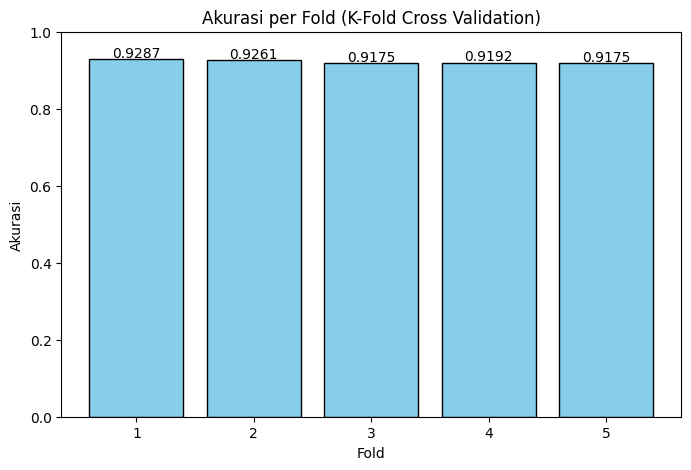


=== RINGKASAN HASIL K-FOLD ===
Fold 1: Akurasi = 0.9287 | Waktu = 15.26 menit
Fold 2: Akurasi = 0.9261 | Waktu = 14.72 menit
Fold 3: Akurasi = 0.9175 | Waktu = 14.97 menit
Fold 4: Akurasi = 0.9192 | Waktu = 15.09 menit
Fold 5: Akurasi = 0.9175 | Waktu = 15.33 menit

Rata-rata Akurasi: 0.9218
Rata-rata Waktu per Fold: 15.07 menit


In [14]:
import matplotlib.pyplot as plt

# Ambil nomor fold
folds = [f + 1 for f in fold_results.keys()]

# Ambil nilai akurasi dari key 'best_acc'
accuracies = [v['best_acc'] for v in fold_results.values()]

# (Opsional) ambil juga waktu training per fold
times = [v['fold_time'] / 60 for v in fold_results.values()]  # ubah jadi menit

# --- Buat grafik akurasi ---
plt.figure(figsize=(8,5))
plt.bar(folds, accuracies, color='skyblue', edgecolor='black')
plt.title("Akurasi per Fold (K-Fold Cross Validation)")
plt.xlabel("Fold")
plt.ylabel("Akurasi")
plt.ylim(0, 1)

# Tambahkan label nilai di atas bar
for i, acc in enumerate(accuracies):
    plt.text(folds[i], acc + 0.005, f"{acc:.4f}", ha='center', fontsize=10)

plt.show()

# --- Cetak statistik tambahan ---
print("\n=== RINGKASAN HASIL K-FOLD ===")
for f, (acc, t) in enumerate(zip(accuracies, times)):
    print(f"Fold {f+1}: Akurasi = {acc:.4f} | Waktu = {t:.2f} menit")

print(f"\nRata-rata Akurasi: {np.mean(accuracies):.4f}")
print(f"Rata-rata Waktu per Fold: {np.mean(times):.2f} menit")